In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
from subprocess import check_output

In [3]:
chunk_1000 = pd.read_csv('../emails.csv', chunksize = 1000)

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
data = next(chunk_1000)

In [6]:
data.info()
print(data.message[2])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
file       1000 non-null object
message    1000 non-null object
dtypes: object(2)
memory usage: 15.7+ KB
Message-ID: <24216240.1075855687451.JavaMail.evans@thyme>
Date: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)
From: phillip.allen@enron.com
To: leah.arsdall@enron.com
Subject: Re: test
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Leah Van Arsdall
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

test successful.  way to go!!!


In [7]:
def get_text(Series, row_num_slicer):
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        del message_words[:row_num_slicer]
        result.iloc[row] = message_words
    return result

def get_row(Series, row_num):

    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        message_words = message_words[row_num]
        result.iloc[row] = message_words
    return result

def get_address(df, Series, num_cols=1):
   
    address = re.compile('[\w\.-]+@[\w\.-]+\.\w+')
    addresses = []
    result1 = pd.Series(index=df.index)
    result2 = pd.Series(index=df.index)
    result3 = pd.Series(index=df.index)
    for i in range(len(df)):
        for message in Series:
            correspondents = re.findall(address, message)
            addresses.append(correspondents)
            result1[i] = addresses[i][0]
        if num_cols >= 2:
            if len(addresses[i]) >= 3:
                result2[i] = addresses[i][1]
                if num_cols == 3:
                    if len(addresses[i]) >= 4:
                        result3[i] = addresses[i][2]
    return result1, result2, result3

def standard_format(df, Series, string, slicer):
    rows = []
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        if string not in message_words[slicer]:
            rows.append(row)
    df = df.drop(df.index[rows])
    return df

In [8]:
x = len(data.index)
headers = ['Message-ID: ', 'Date: ', 'From: ', 'To: ', 'Subject: ']
for i, v in enumerate(headers):
    data = standard_format(data, data.message, v, i)
data = data.reset_index()
print("Got rid of {} useless emails! That's {}% of the total number of messages in this dataset.".format(x - len(data.index), np.round(((x - len(data.index)) / x) * 100, decimals=2)))

Got rid of 38 useless emails! That's 3.8% of the total number of messages in this dataset.


In [9]:
data['text'] = get_text(data.message, 15)
data['date'] = get_row(data.message, 1)
data['senders'] = get_row(data.message, 2)
data['recipients'] = get_row(data.message, 3)
data['subject'] = get_row(data.message, 4)

data.date = data.date.str.replace('Date: ', '')
data.date = pd.to_datetime(data.date)

data.subject = data.subject.str.replace('Subject: ', '')

data['recipient1'], data['recipient2'], data['recipient3'] = get_address(data, data.recipients, num_cols=3)
data['sender'], x, y = get_address(data, data.senders)

del data['recipients']
del data['senders']
del data['file']
del data['message']

data = data[['date', 'sender', 'recipient1', 'recipient2', 'recipient3', 'subject', 'text']]

print(data.head())

                        date                   sender  \
0  2001-05-14 16:39:00-07:00  phillip.allen@enron.com   
1  2001-05-04 13:51:00-07:00  phillip.allen@enron.com   
2  2000-10-18 03:00:00-07:00  phillip.allen@enron.com   
3  2000-10-23 06:13:00-07:00  phillip.allen@enron.com   
4  2000-08-31 05:07:00-07:00  phillip.allen@enron.com   

                recipient1 recipient2  recipient3    subject  \
0     tim.belden@enron.com        NaN         NaN              
1  john.lavorato@enron.com        NaN         NaN        Re:   
2   leah.arsdall@enron.com        NaN         NaN   Re: test   
3    randall.gay@enron.com        NaN         NaN              
4     greg.piper@enron.com        NaN         NaN  Re: Hello   

                                                text  
0                      [, Here is our forecast, ,  ]  
1  [, Traveling to have a business meeting takes ...  
2                 [, test successful.  way to go!!!]  
3  [, Randy,, ,  Can you send me a schedule of th...

In [10]:
import networkx as nx
import nxviz as nv

G = nx.from_pandas_edgelist(data, 'sender', 'recipient1', edge_attr=['date', 'subject'])


/Users/jasongwak/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


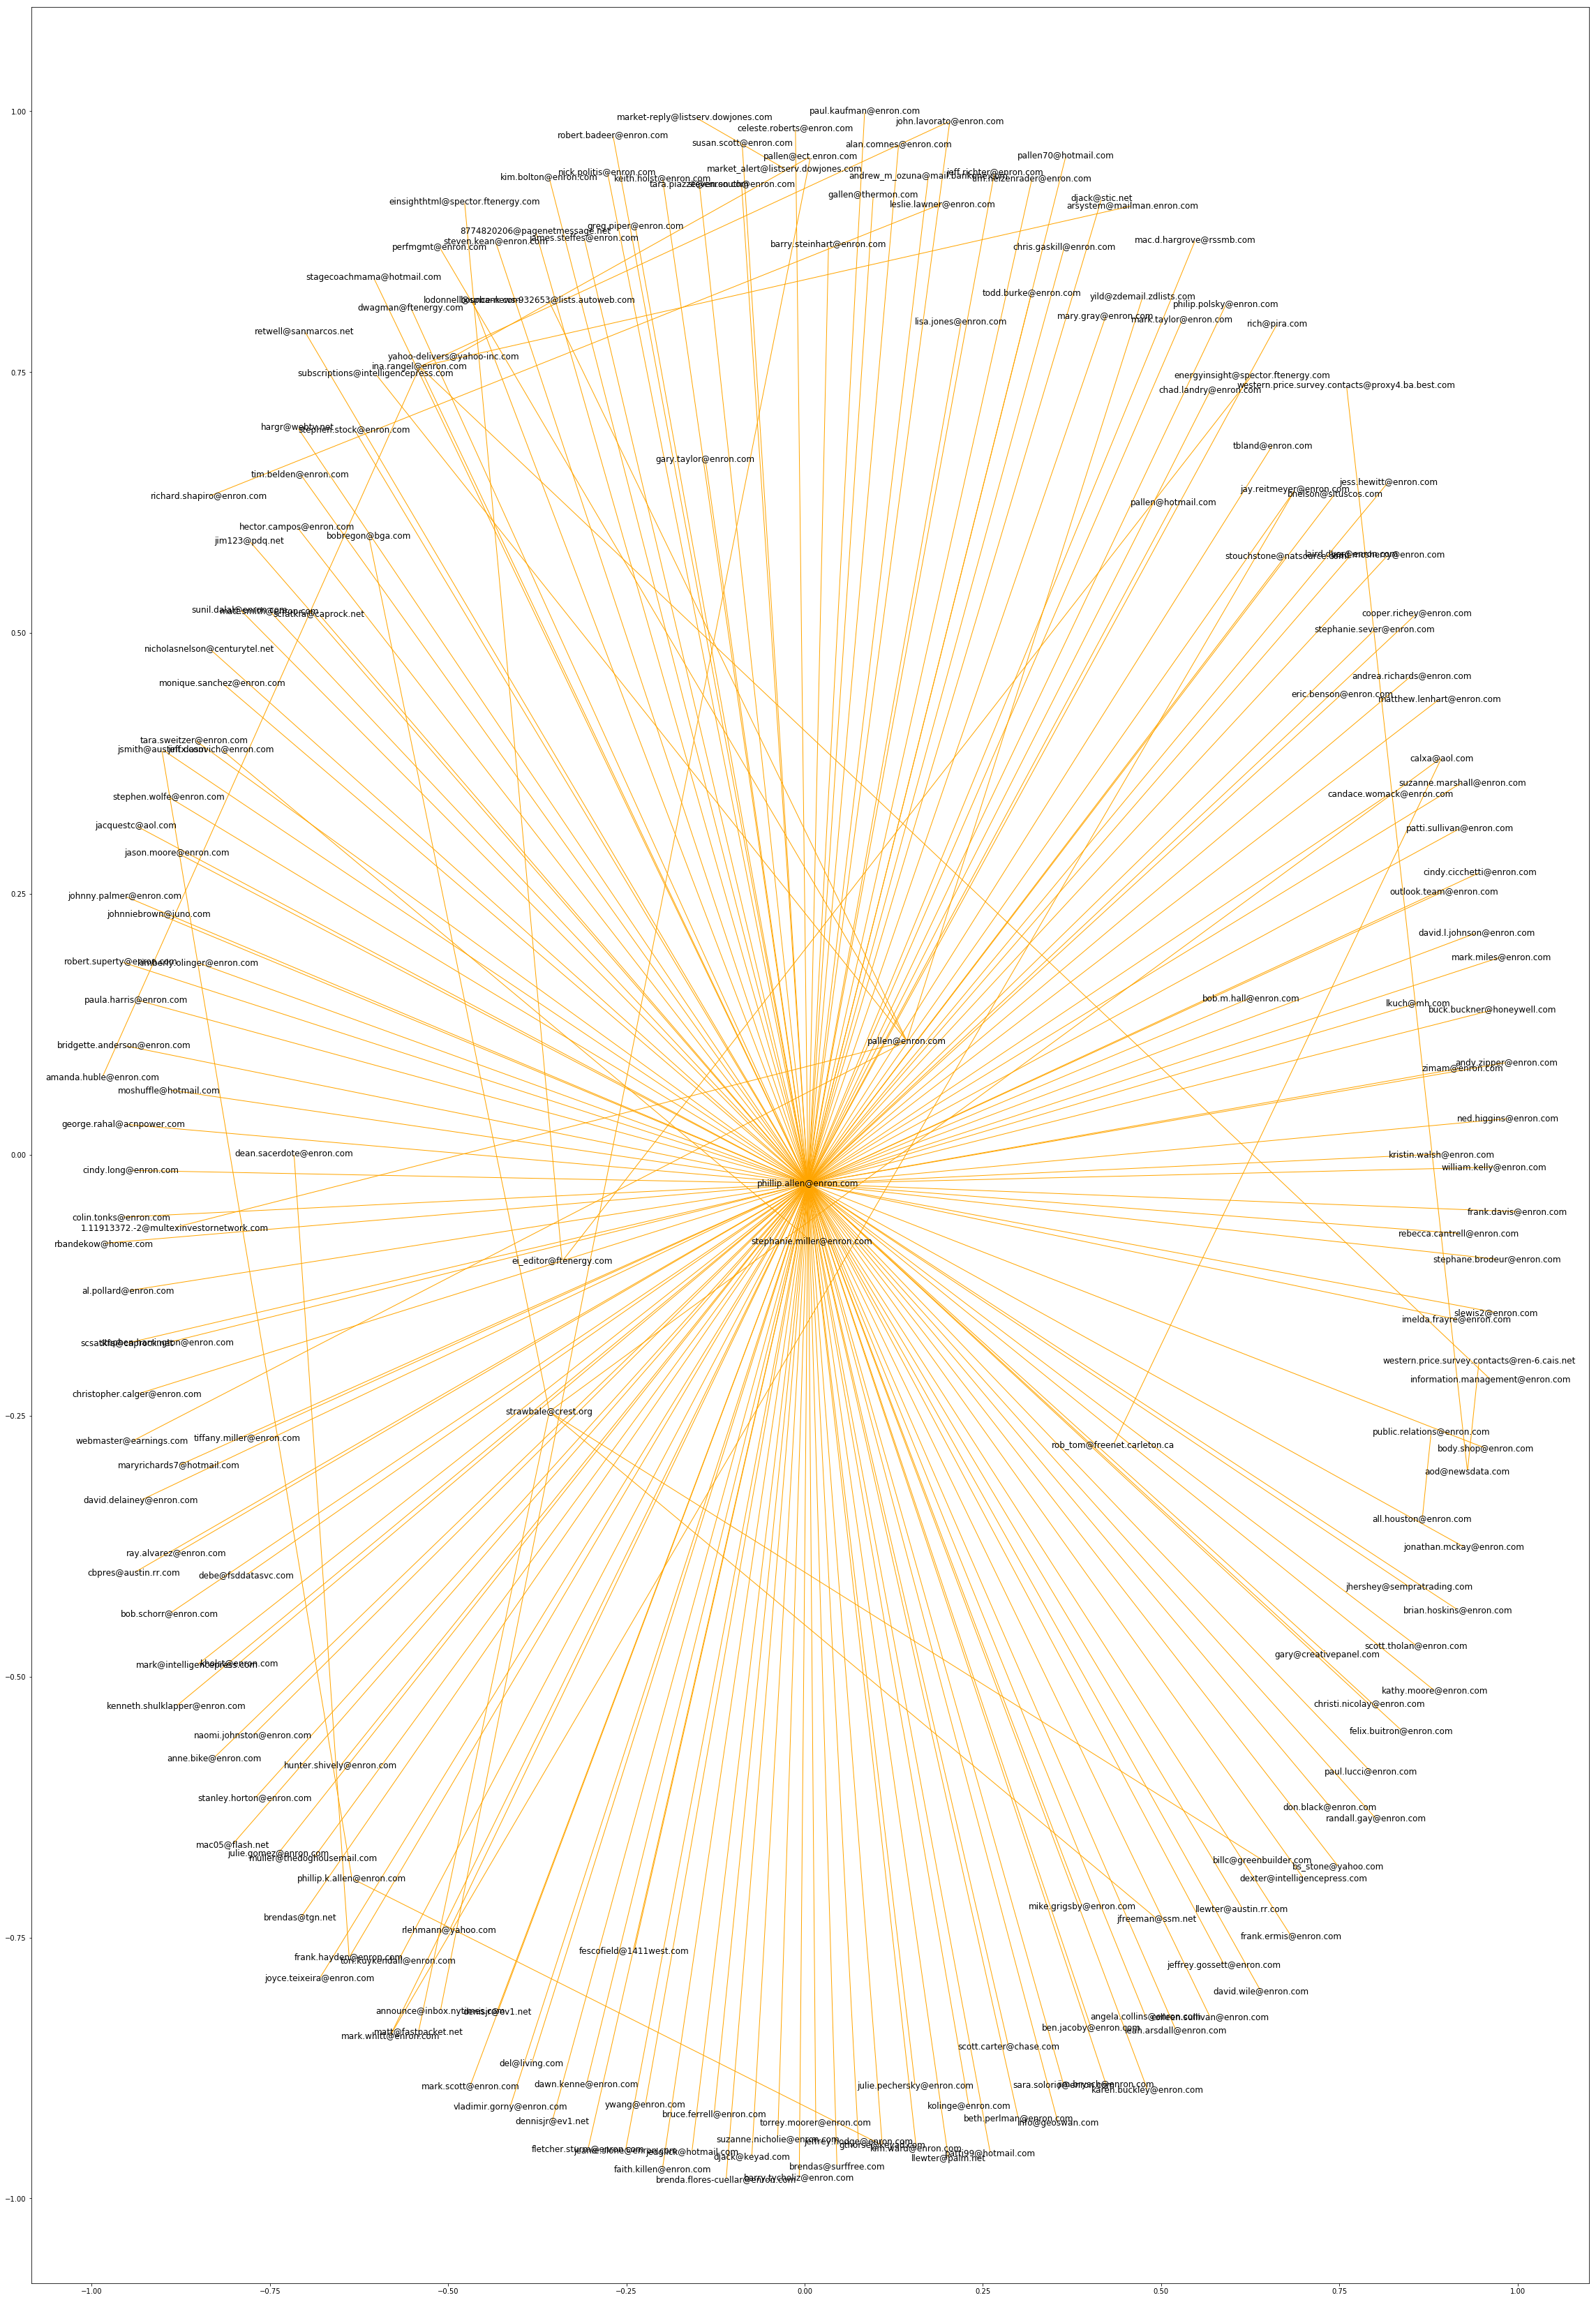

In [12]:
plt.figure(figsize=(40,60))
pos = nx.spring_layout(G, k=1)
nx.draw_networkx(G, pos, node_size=10, node_color='white', with_labels=True, edge_color='orange')
plt.show()